
# **Advanced Lane Line Finding using Images** 
In this notebook, we are going to build a computer vision model for identifying lane lines in road images.

Camera calibration.

Extracting lane line pixels using color thresholding.

Perspective transformation.

Calculating lane curvature.

Producing output images and videos with highlighted lane lines.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import os
from ipywidgets import interact, interactive, fixed
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
import adv_lane_lines 


%matplotlib inline

# **1. Camera Calibration** 
Camera calibration logic is encapsulated in CameraCalibrate class in the adv_lane_lines.py module.
This class's constructor takes following arguments.

A list of camera images which we are going to use for camera calibration.

Number of corners in X direction

Number of corners in Y direction

A boolean flag, if it is True, we do camera calibration and store those calibration data.

The public method of this CameraCalibrate class is undistort and it takes a distorted image as the input and produces an undistorted image.

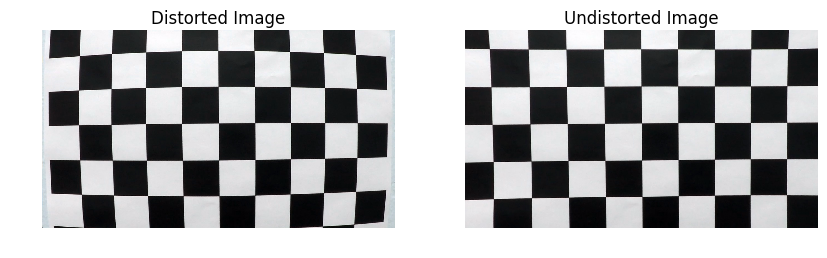

In [2]:
# Camera calibration test
camera_cal_images = glob.glob('../camera_cal/calibration*.jpg')
calibrate = adv_lane_lines.CameraCalibrate(camera_cal_images, 9, 6)
                                        

# Take example distorted image and undistort it using saved camera coefficients
distorted_image = '../camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = calibrate.undistort(distorted_image)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(distorted_image)


plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image')

plt.show()



In [3]:

# Save undistorted images to ./output_images/cameral_cal folder
# 

UNDISTORTED_OUT_IMAGES_LOC = '../output_images/camera_cal/'

for image in camera_cal_images:
    start = image.rindex('/') + 1
    end = image.rindex('.')
    dest_path = UNDISTORTED_OUT_IMAGES_LOC + image[start:end] + '.jpg'
    
    image = cv2.imread(image)
    undistorted_image = calibrate.undistort(image)
    # Save undistorted image
    cv2.imwrite(dest_path, undistorted_image)


In [4]:
def load_test_images(glob_regex='../test_images/*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images




Now our camera calibration class is ready and it will be the first step in the process of finding road lane line using camera images.

Follwing image shows before and after applying distortion correction to a typical road image.

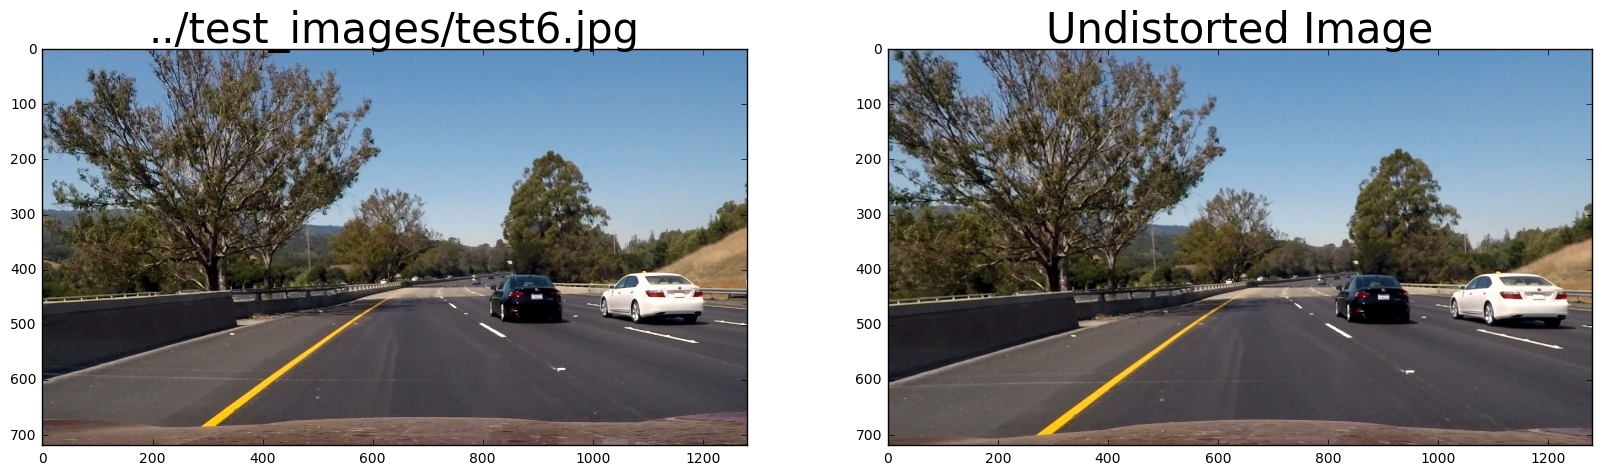

In [5]:

images = load_test_images()

@interact
def undistort_test_images(images=fixed(images), i:(0,len(images)-1)=0):
    file,image=images[i]
    undistorted=calibrate.undistort(image)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title(file, fontsize=30)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
#%load_ext autoreload
#%autoreload 2

# Next we are going to save distrotion corrected images to 
# ./output_images/test_images_ undistorted folder

UNDIST_IMAGES_LOCATION = '../output_images/undistorted_test_images/'
TEST_IMAGES_LOCATION = '../test_images/'
images_loc = os.listdir(TEST_IMAGES_LOCATION)

for image_loc in images_loc:
    corred_image_file = UNDIST_IMAGES_LOCATION + image_loc
    distorted_image_location = TEST_IMAGES_LOCATION + image_loc
    distorted_image_location = cv2.imread(distorted_image_location)
    corrected_image = calibrate.undistort(distorted_image_location)
    cv2.imwrite(corred_image_file, corrected_image)

###  2. Extracting Lane Line Pixels Using Color Thresholding

Correctly identifying lane line pixels is one of the main tasks of this project. In order to identify lane line, we have used three main techniques namely:

Sobel operation in X direction

      Sobel operator is a discrete differential operator. The operator utilizes two 3x3 kernels.
      Sobel operator’s smoothing effect (Gaussian smoothing), it is less sensitive to noise present in images.
      
      
Color thresholding in S component of the HLS color space.


Color thresholding in L component of the HLS color space.

These three operations are encapsulated in the method called **`image_binarize`** in **`adv_lane_lines.py`** module.

Also, below shows the **`image_binarize`** operation applied to a sample image.

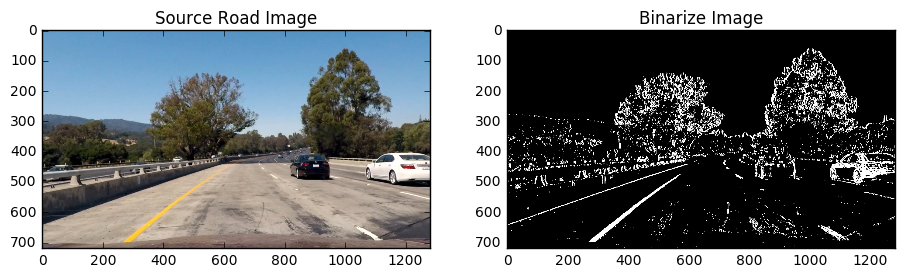

In [7]:

# Now we are ready to do color thresholding and masking 
# in order to find out binary images with lane lines.
output_undistorted_img = mpimg.imread('../output_images/undistorted_test_images/test1.jpg')
binary_img = adv_lane_lines.image_binarize(output_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (170, 255), 
                                                 l_thresh = (50, 255))
plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
plt.axis('on')
plt.title('Source Road Image')
plt.imshow(output_undistorted_img)

plt.subplot(1, 2, 2)
plt.axis('on')
plt.title('Binarize Image')
plt.imshow(binary_img)

plt.show()

In [8]:

# save all binary threshold image to ./output_images/test_images_binary folder

OUTPUT_DIR = '../output_images/test_images_binarized/'
INPUT_DIR = '../output_images/undistorted_test_images/'

for file in os.listdir(INPUT_DIR):
    saved_undistorted_img = mpimg.imread(INPUT_DIR + file)
    binary_img = adv_lane_lines.image_binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
    cv2.imwrite(OUTPUT_DIR + file, binary_img)
print('{} images saved to {} directory'.format(len(os.listdir(INPUT_DIR)),
                                              OUTPUT_DIR))

8 images saved to ../output_images/test_images_binarized/ directory


### 3. Perspective Transformation

The second step of the lane line finding pipeline is "perspective transformation" step. In an image perspective is the phenomenon where objects appear smaller the further away they are from a viewpoint.   

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. We are going to use bird’s-eye view transform that allows us to view a lane from above.
This will be useful for calculating the lane curvature.

Warped operation is encapculated in **`Transformation`** class of the **`adv_lane_lines.py`** package located in **`src`** folder. In order to create an instance of **`PerspectiveTransformer`**  class we need to provide four source and destination points. In order to clearly visible lane lines we have selected following source and destination points. 

|Source Points | Destination Points|
|--------------|-------------------|
|(253, 697)      |    (303, 697)       |
|(585, 456)      |(303, 0)             |
|(700, 456)      |(1011, 0)            |
|(1061, 690)     |(1011, 690)          |


I verified the performance of my perspective transformation by transforming an image (**`../output_images/undistorted_test_images/straight_lines2.jpg`**) using above source and destination points as given below.

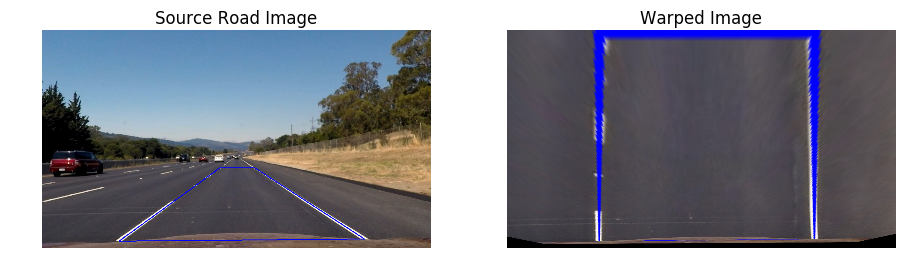

In [9]:
image = mpimg.imread('../output_images/undistorted_test_images/straight_lines2.jpg')

corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

perspective = adv_lane_lines.Transformation(src, dst)


cv2.line(image, (253, 697), (585,456), color=[0,0,255], thickness=2)
cv2.line(image, (585,456), (700, 456), color=[0,0,255], thickness=2)
cv2.line(image, (700, 456), (1061,690), color=[0,0,255], thickness=2)
cv2.line(image, (1061,690), (253, 697), color=[0,0,255], thickness=2)

warped_img = perspective.transform(image)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(image)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

plt.show()

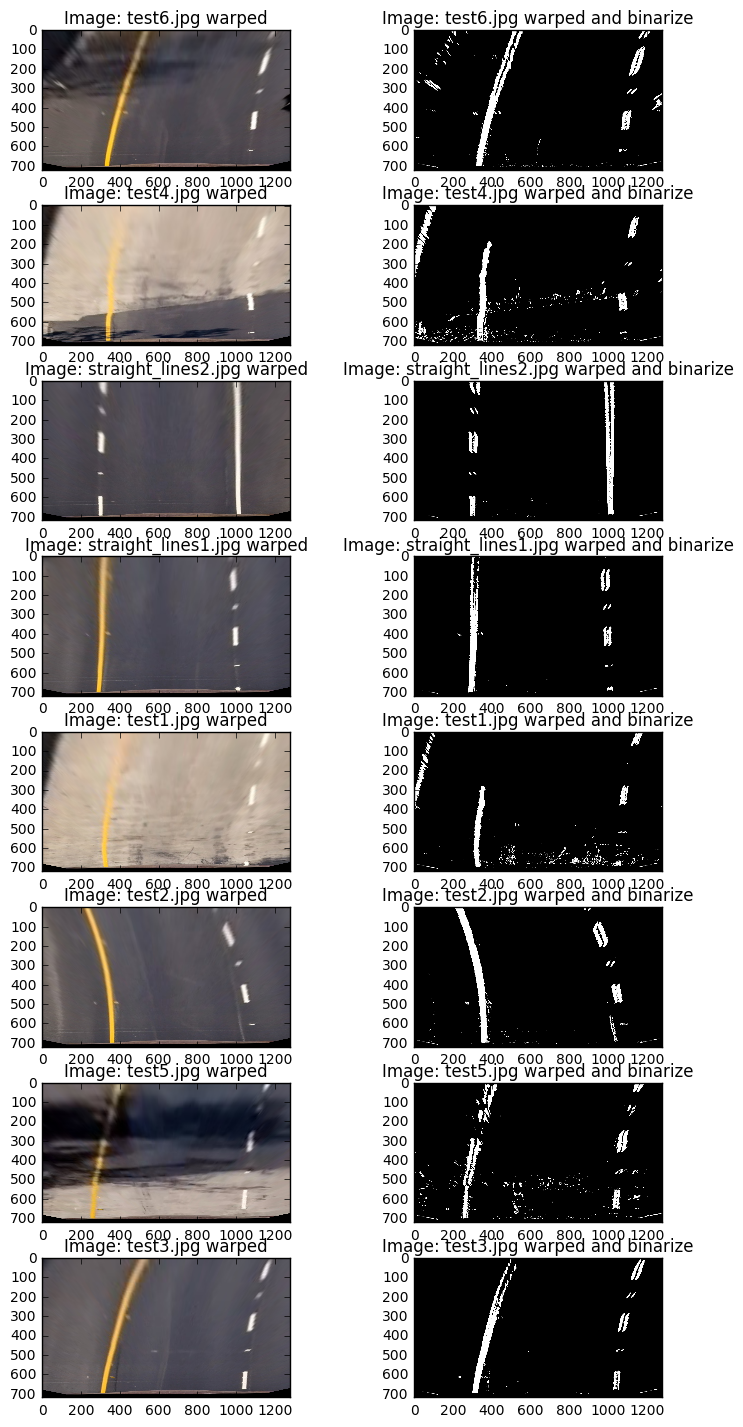

In [10]:
index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)


binary_images = []
for file in os.listdir('../output_images/undistorted_test_images/'):
    image = mpimg.imread('../output_images/undistorted_test_images/' + file)
        
    ax1 = plt.subplot(gs[index])
    undistorted = perspective.transform(image)
    ax1.axis('on')
    ax1.set_title('Image: {} warped'.format(file))
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = adv_lane_lines.image_binarize(undistorted)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('on')
    ax2.set_title('Image: {} warped and binarize'.format(file))
    ax2.imshow(binary_img)
    
    index += 1
    
plt.show()

### 4. Calculating Lane Curvature
Now that we have extracted lane line pixels, next step would be calculating the road curvature.

In order to calculate road curvature, we have used two methods as given below.
1. `basic_lane_finder(self, binary_warped)` (inside the **Line** class in adv_lane_lines module)
2. `advance_lane_finder(self, binary_warped)` (inside the **Line** class in adv_lane_lines module)

Both methods take a binary warped image (similar to one shown above) and produces X coordinates of both left and right lane lines. `basic_lane_finder(self, binary_warped)` method uses **sliding window** to identify lane lines from the binary warped image and then uses a second order polynomial estimation technique to calculate road curvature. 

In following code blocks, explain the algorith we used in the **`basic_lane_finder(self, binary_warped)`** method.

* **`basic_lane_finder(self, binary_warped)`** algorithm expects a binary warped image such as one shown below.

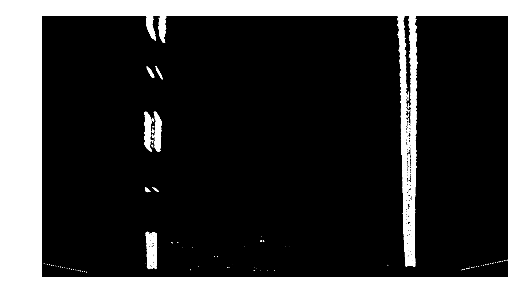

In [11]:
warped_image = binary_images[2] 
plt.imshow(warped_image)
plt.axis('off')
plt.show()

* We calculate a histogram of pixel intencities using the first half (starting from the bottom of the image) the image as shown below.

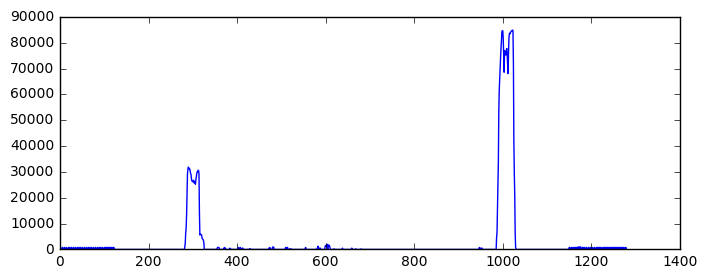

In [12]:
histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()

Calculate the mid point of the histogram and next peack point of left and right haves are calculated.

In [13]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

Peak point of left half: 290
Peak point of right half: 1022


we assign **`leftx_current`** and **`rightx_current`** to the previously calculated peak points. Finally, two containers (**`left_lane_inds`** and **`right_lane_inds`**) are created to store lane line coordinates.

In [14]:
nwindows = 9
window_height = np.int(warped_image.shape[0] / nwindows)

# Extracts x and y coordinates of non-zero pixels
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set current x coordinated for left and right
leftx_current = leftx_base
rightx_current = rightx_base

margin = 75
min_num_pixels = 35

# save pixel ids in these two lists
left_lane_inds = []
right_lane_inds = []

Main task of lane curvature calculation process. 

1. It iterate **`nwindows`** times and in each iteration:
2. Search rectangle reagons near the **`leftx_current`** and **`rightx_current`** and find white pixel ids and addd thoese ids to **`left_lane_inds`** and **`right_lane_inds`** arrays.
3. Update **`leftx_current`** and **`rightx_current`** variables.
4. Calcuate X and Y coordinates of the white pixels those are belonging to left and right lane lines.
5. Using those calculated X and Y coordinates we fit a second order polynomial.
5. Using calculated polynomial coefficients, we caculate X coordinate of the lane line for each Y coordinate.

Finally, draw polynomial lines and calcuated lane line pixels for one of the testing images in order to verify our algorithm.

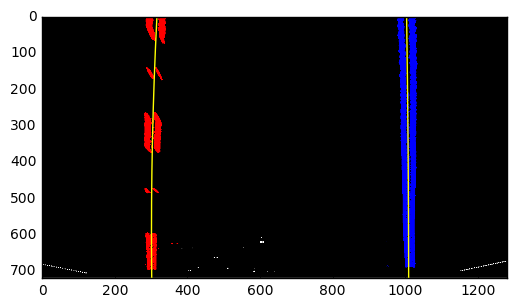

In [15]:

for window in range(nwindows):
    win_y_low = warped_image.shape[0] - (window + 1) * window_height
    win_y_high = warped_image.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_array_inds = np.concatenate(left_lane_inds)
right_lane_array_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array_inds]
lefty = nonzeroy[left_lane_array_inds]
rightx = nonzerox[right_lane_array_inds]
righty = nonzeroy[right_lane_array_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

warped_image[nonzeroy[left_lane_array_inds], nonzerox[left_lane_array_inds]] = [255, 0, 0]
warped_image[nonzeroy[right_lane_array_inds], nonzerox[right_lane_array_inds]] = [0, 0, 255]
plt.imshow(warped_image)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

We calculate actual road curvature (in meters) and we calculate how much the vehicle is drifted from the center of the lane. These two calculation are done inside the **`left_right_curvature_road(self, image_size, left_x, right_x)`** method of the **`LaneLines`** class.

### 5. Producing output images and videos with highlighted lane lines

In order to easy work with images as well as videos, I created a Python class called **`LaneLines`** inside the **`adv_lane_lines`** module. It encapsulates all the methods we described above and helper methods as well.  

The key method of **`LaneLines`** class is **`processpipe(self, image)`** method. It takes a single image as the input. That image goes through the image process pipeline as described above and finally produces another image which contains highlighted lane line, lane line curvature information and the content of the original image.



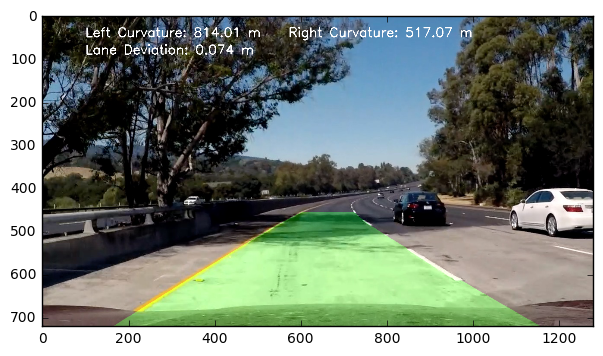

In [16]:
#Test the processpipe function 
src_image = mpimg.imread('../test_images/test5.jpg')

line = adv_lane_lines.LaneLines()
output_image = line.processpipe(src_image)

plt.figure(figsize=(10, 4))
plt.axis('on')
plt.imshow(output_image)
plt.show()

In [17]:
#Test the project video file 
output_file = '../processed_project_video.mp4'
input_file = '../project_video.mp4'
line = adv_lane_lines.LaneLines()

clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line.processpipe) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ../processed_project_video.mp4
[MoviePy] Writing video ../processed_project_video.mp4


100%|█████████▉| 1260/1261 [03:28<00:00,  6.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../processed_project_video.mp4 

